## 1. Carregar os Dados e Separar o Tempo ⏳
A regra mais importante do desafio é: "Validação: splits temporais. Evite shuffle aleatório puro". Isso significa que não podemos embaralhar os dados. Temos que treinar com dados "velhos" (ex: 2023 e começo de 2024) e testar com dados "novos" (final de 2024), simulando a vida real.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Configuração visual
sns.set_theme(style="whitegrid")

# Caminhos
PROCESSED_DIR = '../data/processed'
arquivo_entrada = f'{PROCESSED_DIR}/base_modelagem.csv'

print("📂 Carregando base de modelagem...")
df = pd.read_csv(arquivo_entrada, sep=';', parse_dates=['DT_COMPTC'])

# Ordenar por data é obrigatório para Split Temporal
df.sort_values(by='DT_COMPTC', inplace=True)

# Remover linhas com infinito ou NaN que podem ter sobrado
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print(f"✅ Dados prontos: {df.shape[0]} linhas.")
print(f"Período: {df['DT_COMPTC'].min()} até {df['DT_COMPTC'].max()}")

📂 Carregando base de modelagem...
✅ Dados prontos: 4058 linhas.
Período: 2024-06-05 00:00:00 até 2025-11-17 00:00:00


## 2. O Split Temporal (Passado vs Futuro)
Vamos definir uma data de corte. Tudo o que aconteceu antes dessa data, o modelo "vê" para aprender. Tudo o que aconteceu depois, ele "não vê" e tenta adivinhar.

In [2]:
# Definindo as Features (X) e o Target (y)
features = [
    'RET_ACC_21D', 'RET_ACC_63D', 'RET_ACC_126D',
    'VOL_21D', 'VOL_63D', 'VOL_126D',
    'PL_LAG1'
]
target = 'TARGET_FLOW_21D'

# Data de corte: Vamos deixar os últimos 3 meses para teste (simulação do mundo real)
# Pega a data máxima e subtrai 90 dias
data_corte = df['DT_COMPTC'].max() - pd.Timedelta(days=90)

print(f"✂️ Separando dados. Data de corte: {data_corte.date()}")

# Filtra
X_train = df[df['DT_COMPTC'] < data_corte][features]
y_train = df[df['DT_COMPTC'] < data_corte][target]

X_test = df[df['DT_COMPTC'] >= data_corte][features]
y_test = df[df['DT_COMPTC'] >= data_corte][target]

print(f"📚 Treino: {X_train.shape[0]} amostras (Até o corte)")
print(f"📝 Teste:  {X_test.shape[0]} amostras (Após o corte)")

✂️ Separando dados. Data de corte: 2025-08-19
📚 Treino: 3343 amostras (Até o corte)
📝 Teste:  715 amostras (Após o corte)


## 3. Treinando o Modelo (A Mágica) ✨
Vamos usar uma Regressão Linear. Ela é ótima para começar porque nos diz exatamente qual variável importa mais (positiva ou negativamente).

🤖 Treinando Regressão Linear (Baseline)...
------------------------------
📊 RESULTADOS (BASELINE):
RMSE (Erro Médio): 0.0812
R² (Explicação):   -0.0132 (Quanto mais perto de 1.0, melhor)
------------------------------


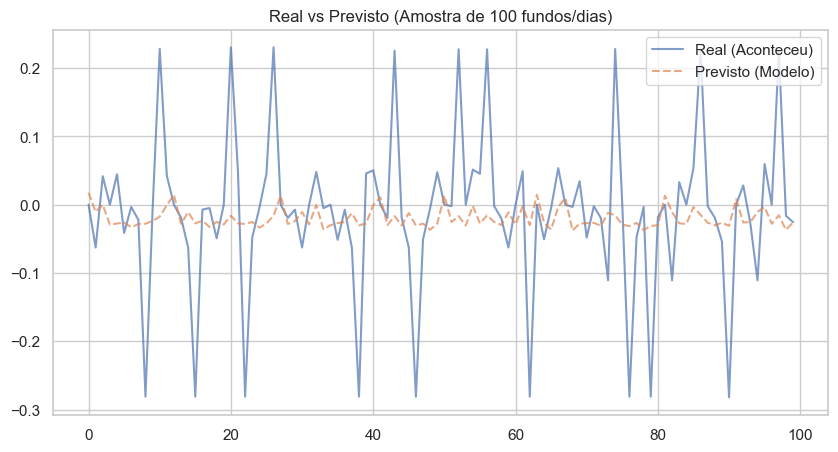

In [3]:
print("🤖 Treinando Regressão Linear (Baseline)...")

# Cria e treina o modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Faz previsões na base de Teste (que ele nunca viu)
y_pred = modelo.predict(X_test)

# Métricas de Erro
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("-" * 30)
print(f"📊 RESULTADOS (BASELINE):")
print(f"RMSE (Erro Médio): {rmse:.4f}")
print(f"R² (Explicação):   {r2:.4f} (Quanto mais perto de 1.0, melhor)")
print("-" * 30)

# Gráfico: Previsão vs Realidade (Vamos plotar apenas 100 pontos para não poluir)
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Real (Aconteceu)', alpha=0.7)
plt.plot(y_pred[:100], label='Previsto (Modelo)', alpha=0.7, linestyle='--')
plt.title("Real vs Previsto (Amostra de 100 fundos/dias)")
plt.legend()
plt.show()

## 4. O que importa? (Feature Importance)
Aqui está o ouro para o seu relatório. O modelo vai dizer: "A volatilidade assusta o cliente?" ou "O retorno de curto prazo atrai o cliente?".


🔍 O que o modelo aprendeu?
        Feature  Peso (Importância)
5      VOL_126D        1.000423e-01
1   RET_ACC_63D        5.035379e-02
0   RET_ACC_21D        2.469042e-02
6       PL_LAG1        3.075520e-10
2  RET_ACC_126D       -3.765846e-02
4       VOL_63D       -4.638430e-02
3       VOL_21D       -1.112090e-01


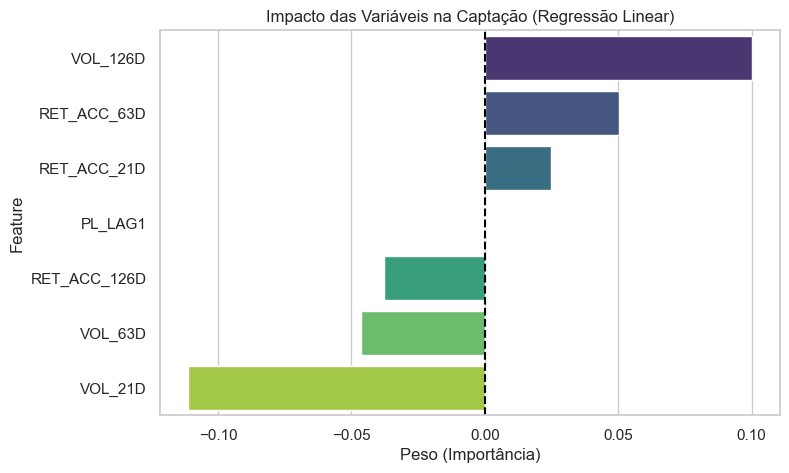

In [4]:
# Criando um DataFrame para ver os pesos
importancia = pd.DataFrame({
    'Feature': features,
    'Peso (Importância)': modelo.coef_
}).sort_values(by='Peso (Importância)', ascending=False)

print("\n🔍 O que o modelo aprendeu?")
print(importancia)

# Gráfico de barras dos pesos
plt.figure(figsize=(8, 5))
sns.barplot(data=importancia, x='Peso (Importância)', y='Feature', hue='Feature', palette='viridis')
plt.title("Impacto das Variáveis na Captação (Regressão Linear)")
plt.axvline(0, color='black', linestyle='--') # Linha do zero
plt.show()